<h1>Contains solutions for the SQF dataset<h1>

In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')

In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence 1.ipynb', 'acs_influence all solutions.ipynb', 'acs_influence_new.ipynb', 'adult.data', 'adult.test', 'adult_influence 1.ipynb', 'adult_influence copy.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence 1.ipynb', 'compas_influence.ipynb', 'config.json', 'entropy_test.ipynb', 'expl.py', 'functions.py', 'german.data', 'german_influence 1 copy.ipynb', 'german_influence 1.ipynb', 'german_influence.ipynb', 'influence.py', 'influence_functions.ipynb', 'load_dataset.py', 'loss.py', 'metrics.py', 'meu_test.ipynb', 'random_influence.ipynb', 'sqf_influence 1.ipynb', 'sqf_influence.ipynb', 'sqf_test.csv', 'sqf_train.csv', 'utils.py', '__pycache__']


In [3]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('frisked')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['frisked'] = changed_df_labels

    return y_predicted


In [4]:
#List of time taken
sol_time = []

In [5]:
dataset = 'sqf'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [6]:
X_train, X_test, y_train, y_test = load(dataset)

In [7]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [8]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
predictors = ['race', 'build', 'age', 'ht_feet', 'weight', 'perobs', 'cs_objcs',
       'cs_descr', 'cs_casng', 'cs_lkout', 'cs_drgtr', 'cs_vcrim', 'ac_proxm',
       'inout_I', 'inout_O', 'sex_F', 'sex_M']
target_var =['frisked']

In [10]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
#train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [11]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [12]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.06874626497856756
Initial TPR parity:  -0.06270783144277586
Initial predictive parity:  -0.07477904554118925
Initial accuracy:  0.6829706361471952


<h5>INF calc on Original Labels for Leave One Out<h5>

In [13]:
#if_start = time.time()
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [14]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 48605/48605 [04:34<00:00, 176.81it/s]


In [15]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [16]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [17]:
#multiple the inverse by -1
negative_hinv_v = -1*hinv_v

In [18]:
inf = np.matmul(np.transpose(negative_hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [19]:
inf = (-1/(len(X_train))) *inf 

In [20]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]

<h5>Leave one out <h5>

In [21]:
#Removal using leave one out concept
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    parity = parity-spd_0

    difference.append(parity)
#This does not fall under the measuring the time taken to decide how long it will take for IF to work 

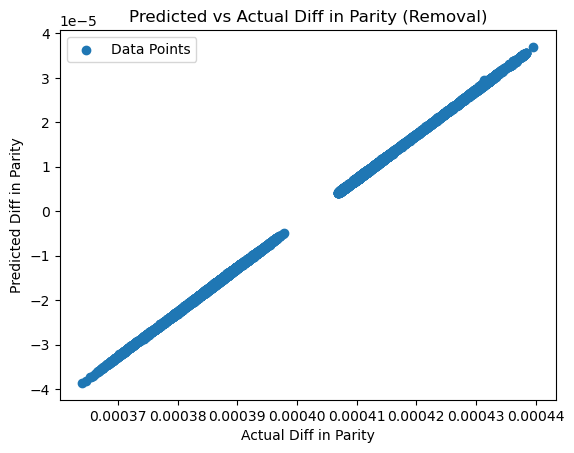

In [22]:
predicted_diff = decimal_array
#actual_diff = actual_parity_list
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h3>INF calc on flipped labels and compare them to flipping the datapoints<h3>

In [23]:
flipping_time_start = time.time()
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})

In [24]:
num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [25]:
clf_2 = eval(clf_name)(input_size=X_train.shape[-1])
clf_2.fit(X_train, y_train_changed)

y_pred_test = clf_2.predict_proba(X_test)
y_pred_train = clf_2.predict_proba(X_train)

spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_1)

Initial statistical parity:  0.06832083893440899


In [26]:
#RP_code
del_L_del_theta_2 = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)
hinv_v_2, hinv_2 = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta_2 - del_L_del_theta))
negative_hinv_v_2 = -1*hinv_v_2
inf_2 = np.matmul(np.transpose(negative_hinv_v_2), del_F_del_theta)
inf_2 = (1/(len(X_train))) *inf_2 

In [27]:
flipping_time_end = time.time()-flipping_time_start

In [28]:
#Flipping
#Make the original flips to test for the parity after each flip 
actual_df_train = train_full_df.copy()
actual_parity_list = []

for index, row in actual_df_train.iterrows():
    if row['frisked'] == 1:
        #Flip the label at frisked = 1 to 0
        actual_df_train.at[index,'frisked'] = 0
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity - spd_0)
        actual_df_train.at[index,'frisked'] = 1
        
    elif row['frisked'] == 0:
        actual_df_train.at[index,'frisked'] = 1
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity - spd_0)
        actual_df_train.at[index,'frisked'] = 0

In [29]:
decimal_array = [format(num, '.10f') for num in inf_2]
decimal_array = [float(num) for num in decimal_array]

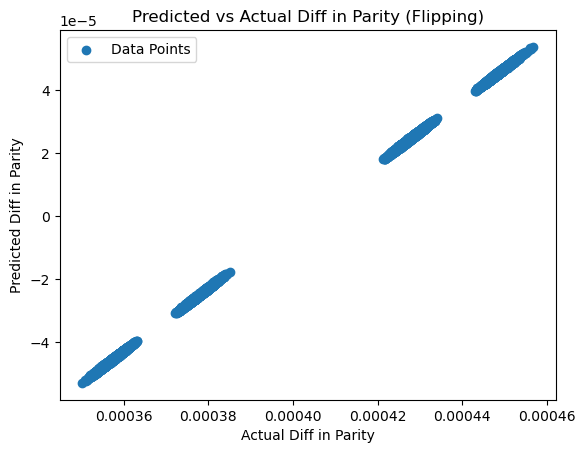

In [30]:
predicted_diff = decimal_array
actual_diff = actual_parity_list

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


<h3>##########################################################################################<h3>

<h4>Make flips based on the flipping_total_inf value<h4>

In [31]:
if_start = time.time()
index_list = []
for i in range(len(X_train)):
    index_list.append(i)

In [32]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [33]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(inf_2, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: x[0], reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)
#Measure up to here for the influence functions
#This will tell us how long it takes for influence functions to determine which order I need to flip the datapoints in
#if_time: Time taken to decide the order in which the datapoints need to be flipped
if_end = time.time() - if_start
if_end += flipping_time_end
print(if_end)

9.493582248687744


In [34]:
if if_end < 0:
    if_end = -1 * if_end
else: 
    pass

In [35]:
#Making flips based on the influence of each datapoint
#After ordering them in decreasing order based on magnitude
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'frisked'] == 1:
        influence_train_copy.at[row_num,'frisked'] = 0
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
    elif influence_train_copy.at[row_num,'frisked'] == 0:
        influence_train_copy.at[row_num,'frisked'] = 1
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
#print(flip_parity_abs)

In [36]:
sol_time.append(if_end)

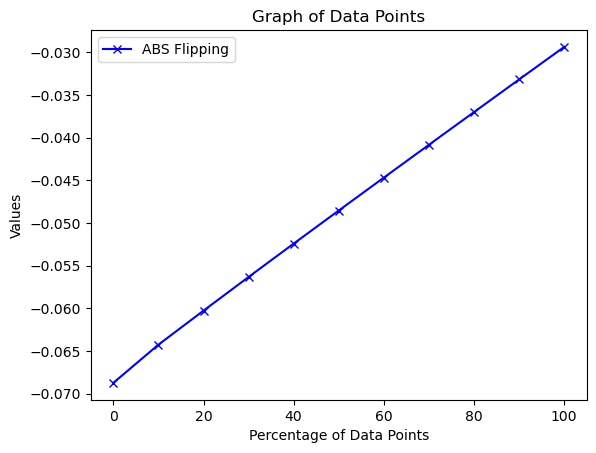

In [37]:
#total num of data points
#on_abs_sorted = len(flip_parity_sorted)
abs_sorted = len(flip_parity_abs)

#Calculate the indices for the 5 points
#indices_non_abs = [int(i * non_abs_sorted / 5) for i in range(0, 5)]
indices_abs = [int(i * abs_sorted / 10) for i in range(0, 10)]

# Extract the values at these indices
#values_non_abs = [flip_parity_sorted[index] for index in indices_non_abs]
values_abs = []
values_abs.append(spd_0)
for index in range(1, len(indices_abs) + 1):
    values_abs.append(flip_parity_abs[index * 80 - 1])
    
# values_abs[0] = flip_parity_abs[0]
# values_abs = [flip_parity_abs[index] for index in indices_abs]

#Plot the Values
plt.plot([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_abs, label='ABS Flipping', color='Blue', marker = 'x')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()

<h3>Compare methods of: Entropy, and IF<h3>

<h4>Uncertainty Reduction/Entropy<h4>

In [38]:
entropy_start = time.time()
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [39]:
#Calculate the probability of each datapoint using the same one of as the lrmodel function
orig_entropy_prob = clf.predict_proba(X_train)
flipped_entropy_prob = 1-orig_entropy_prob

In [40]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index in range(len(X_train)):
  #Calculate p1 and p2
  p1=orig_entropy_prob[index]
  p2=flipped_entropy_prob[index]
  #print(f"Index: {index}, p1: {p1}, p2: {p2}")
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2) if p1 > 0 else 0
  entropy_calc2 = p2 * math.log(p2,2) if p2 > 0 else 0
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [41]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)
entropy_end = time.time() - entropy_start

In [42]:
entropy_train_df['frisked'] = entropy_train_df['frisked'].astype('int')

In [43]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [44]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

# ranked_ent_parity_list = [spd_0]
ranked_ent_parity_list = []
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'frisked'] == 0:
        entropy_train_df.at[row_num,'frisked'] = 1
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'frisked'] == 1:
        entropy_train_df.at[row_num,'frisked'] = 0
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

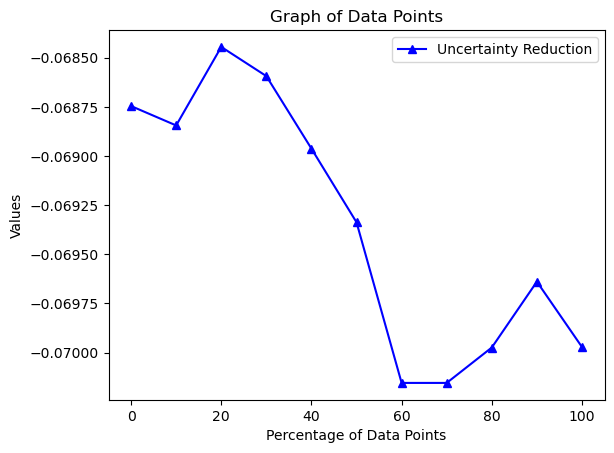

In [45]:
datapoints_ent = len(ranked_ent_parity_list)

#indices at 10 points along the graph
indices = [int(i * datapoints_ent / 10) for i in range(0, 10)]

# # Extract the values at these indices
# values_entropy = [ranked_ent_parity_list[index] for index in indices]

values_entropy = []
values_entropy.append(spd_0)
for index in range(1, len(indices) + 1):
    values_entropy.append(ranked_ent_parity_list[index * 80 - 1])

#Plot the Values
plt.plot([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_entropy, label='Uncertainty Reduction', color='Blue', marker = '^')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()

In [46]:
sol_time.append(entropy_end)

<h4>Randomized flipping<h4>

In [47]:
#Training dataset
random_start = time.time()
random_training_df = train_full_df.copy()

In [48]:
import random
rand_val = list(range(len(X_train)))
random.shuffle(rand_val)
random_end = time.time() - random_start

In [49]:
#Iterate through the ranked list and start the flipping
random_flip_parity = []
for row in rand_val:
    if random_training_df.at[row,'frisked'] == 1:
        random_training_df.at[row,'frisked'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[row, 'frisked'] == 0:
        random_training_df.at[row,'frisked'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)

In [50]:
#random flipping
'''random_flip_parity = []

for iter in range(budget):
    random_row = random.choice(random_training_df.index)
    if random_training_df.at[random_row,'credit_risk'] == 1:
        random_training_df.at[random_row,'credit_risk'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[random_row,'credit_risk'] == 0:
        random_training_df.at[random_row,'credit_risk'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
random_end = time.time()'''


"random_flip_parity = []\n\nfor iter in range(budget):\n    random_row = random.choice(random_training_df.index)\n    if random_training_df.at[random_row,'credit_risk'] == 1:\n        random_training_df.at[random_row,'credit_risk'] = 0\n        rand_pred = lr_model(random_training_df, X_test, clf)\n        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)\n        random_flip_parity.append(rand_ranked_parity)\n    elif random_training_df.at[random_row,'credit_risk'] == 0:\n        random_training_df.at[random_row,'credit_risk'] = 1\n        rand_pred = lr_model(random_training_df, X_test, clf)\n        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)\n        random_flip_parity.append(rand_ranked_parity)\nrandom_end = time.time()"

In [51]:
sol_time.append(random_end)

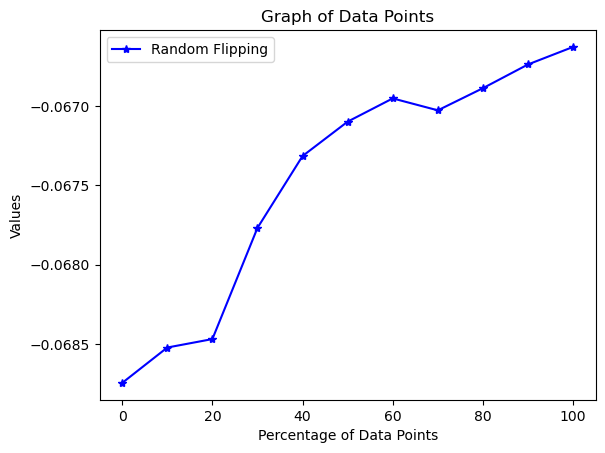

In [52]:
datapoints_rand = len(random_flip_parity)

#indices at 10 points along the graph
indices = [int(i * datapoints_rand / 10) for i in range(0, 10)]

# Extract the values at these indices
# values_rand = [random_flip_parity[index] for index in indices]

values_rand = []
values_rand.append(spd_0)
for index in range(1, len(indices) + 1):
    values_rand.append(random_flip_parity[index * 80 - 1])

#Plot the Values
plt.plot([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_rand, label='Random Flipping', color='Blue', marker = '*')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()

<h4>Graph of outcomes<h4>

[0, 4860, 9721, 14581, 19442, 24302, 29163, 34023, 38884, 43744, 48605]
[0, 4860, 9721, 14581, 19442, 24302, 29163, 34023, 38884, 43744, 48605]
[0, 4860, 9721, 14581, 19442, 24302, 29163, 34023, 38884, 43744, 48605]


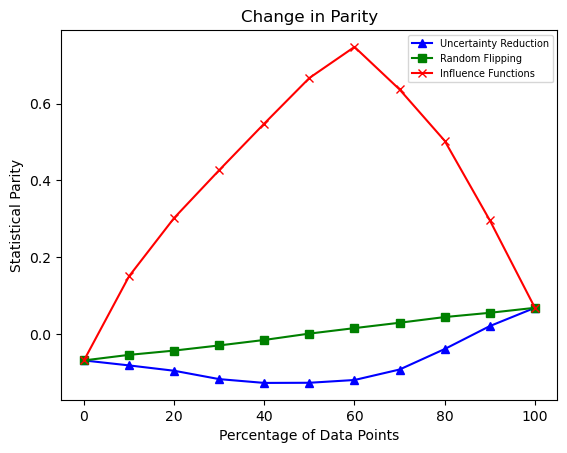

In [58]:
# Calculate the total number of data points
#datapoints_iterative = len(ranked_greedy_parity_list)
datapoints_entropy = len(ranked_ent_parity_list)
#datapoints_meu = len(meu_ranked_parity_list)
datapoints_random = len(random_flip_parity)
datapoints_influence = len(flip_parity_abs)

# Calculate the indices for the 5 points
#indices_iterative = [int(i * datapoints_iterative / 10) for i in range(0, 11)]
indices_entropy = [int(i * datapoints_entropy / 10) for i in range(0, 11)]
#indices_meu = [int(i * datapoints_meu / 10) for i in range(0, 11)]
indices_random = [int(i * datapoints_random / 10) for i in range(0, 11)]
indices_influence = [int(i * datapoints_influence / 10) for i in range(0, 11)]

#print(indices_iterative)
print(indices_entropy)
#print(indices_meu)
print(indices_random)
print(indices_influence)

#These should be the same?

# Extract the values at these indices
# values_iterative = [ranked_greedy_parity_list[index] for index in indices_iterative]
# values_entropy = [ranked_ent_parity_list[index * 80 - 1] for index in indices_entropy]
# values_meu = [meu_ranked_parity_list[index * 80 - 1] for index in indices_meu]
# values_random = [random_flip_parity[index * 80 - 1] for index in indices_random]
# values_influence = [flip_parity_abs[index * 80 - 1] for index in indices_influence]

#values_iterative = []
values_entropy = []
#values_meu = []
values_random = []
values_influence = []
#values_iterative.append(spd_0)
values_entropy.append(spd_0)
#values_meu.append(spd_0)
values_random.append(spd_0)
values_influence.append(spd_0)
for index in range(1, len(indices) + 1):
    #values_iterative.append(ranked_greedy_parity_list[index * 80 - 1])
    values_entropy.append(ranked_ent_parity_list[index * 4860 - 1])
    #values_meu.append(meu_ranked_parity_list[index * 80 - 1])
    values_random.append(random_flip_parity[index * 4860 - 1])
    values_influence.append(flip_parity_abs[index * 4860 - 1])



# Plot the values
# plt.plot(values_iterative, label='Iterative Flipping', color='Orange')
# plt.plot(values_entropy, label='Entropy', color='Blue')
# plt.plot(values_meu, label='MEU', color='Yellow')
# plt.plot(values_random, label='Random Flipping', color='Green')
# plt.plot( values_influence, label='Influence Flipping', color='Red')
#plt.plot([0, 10,20, 30, 40, 50, 60, 70, 80, 90, 100], values_iterative, label='Iterative Flipping', color='Orange')
plt.plot([0, 10,20, 30, 40, 50, 60, 70, 80, 90, 100], values_entropy, label='Uncertainty Reduction', color='Blue', marker='^')
#plt.plot([0, 10,20, 30, 40, 50, 60, 70, 80, 90, 100], values_meu, label='MEU', color='magenta')
plt.plot([0, 10,20, 30, 40, 50, 60, 70, 80, 90, 100], values_random, label='Random Flipping', color='Green', marker='s')
plt.plot([0, 10,20, 30, 40, 50, 60, 70, 80, 90, 100], values_influence, label='Influence Functions', color='Red', marker='x')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Statistical Parity')
plt.title('Change in Parity')
plt.legend(loc='upper right', fontsize='7')

<h4>Time Comparisons<h4>

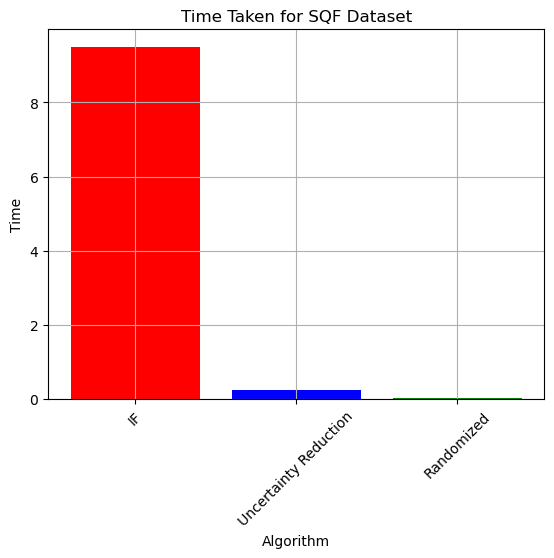

In [54]:
# Create a line chart
x_axis = ['IF', 'Uncertainty Reduction', 'Randomized']
# Colors for each bar
colors = ['red', 'blue', 'green']

# Create a bar graph with updated labels and colors
plt.bar(x_axis, sol_time, color=colors)
plt.title('Time Taken for SQF Dataset')
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [55]:
#When calculating the time we are looking at the time taken to choose which datapoint to flip 
#Do not consider the time taken to calculate the fairness on each datapoint
#Also when implementing the other solutions on the bigger datasets do not implement MEU and greedy due to the expense of it
#Instead implement IF, Entropy, and randomized

#Since our solution is looking to determine the efficiency at which the datapoints are selected we want to measure the time 
#taken to determine which order the datapoints should be flipped in
#Measure how long it takes to determine which datapoints need to be flipping and do not consider the parity calculations
print(sol_time)

[9.493582248687744, 0.24692893028259277, 0.03151655197143555]


In [56]:
print(flip_parity_abs[-1])
#print(ranked_greedy_parity_list[-1])
print(ranked_ent_parity_list[-1])
#print(meu_ranked_parity_list[-1])
print(random_flip_parity[-1])

0.06834360432364484
0.0683430766134463
0.06834326187882
